### End to End Evaluation for PVNet
This notebook provides steps to evaluate PVNet on a same dataset that is being used for Mask R-CNN evaluation.

In [1]:
import sys
# Simulated script arguments
sys.argv = ['script_name', '--det', 'example_det', '--type', 'example_type']

In [2]:
from lib.config import cfgs
from cobot_pipeline import make_and_load_pvnet

# Configs/Models in the order 0: mainshell, 1: topshell, 2: insert_mold 
pvnets = tuple([make_and_load_pvnet(c) for c in cfgs])

Load model: data/model/pvnet/mainshell/30.pth
Load model: data/model/pvnet/topshell/50.pth
Load model: data/model/pvnet/insert_mold/25.pth


In [3]:
import os
import json

dataset_path = "/pvnet/data/FIT/end2end"
pvnet_base_dir = os.path.join(dataset_path, "pvnet")
pvnet_annotation_path = os.path.join(pvnet_base_dir, "pvnet.json")
maskrcnn_csv_path = os.path.join(pvnet_base_dir, "eval_output_for_pvnet.csv")

with open(pvnet_annotation_path, 'r') as file:
    pvnet_annotation = json.load(file)
    
# Example of pvnet annotation for each instance
print(pvnet_annotation.keys())
print(pvnet_annotation['0'].keys())
print(pvnet_annotation['0']['instances'][0].keys())
print(pvnet_annotation['0']['instances'][0]['category_id']) #COCO format: 1-mainshell, 2-topshell, 3-insert_mold

dict_keys(['0', '1', '2'])
dict_keys(['camera_K', 'camera_pose_in_world', 'instances'])
dict_keys(['instance_id', 'category_id', 'cropped_rgb', 'cropped_mask', 'uv', 'pose_in_cam', 'pose_in_world'])
3


In [11]:
import os
import cv2
import torch
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from lib.datasets.transforms import make_transforms
from lib.utils.pvnet import pvnet_pose_utils
from mrcnn.stable_poses_est import construct_T_stable_from_T_est
from cobot_pvnet import draw_axis

class Evaluator:
    def __init__(self, pvnet_annotation, categories, pvnet_models, cfgs, base_dir, maskrcnn_csv_path):
        self.pvnet_annotation = pvnet_annotation
        self.categories = categories
        self.pvnet_models = pvnet_models
        self.cfgs = cfgs
        self.base_dir = base_dir
        self.maskrcnn_csv_path = maskrcnn_csv_path
        self.dataset_dir = os.path.dirname(base_dir)
        self.cropping_size = 128
        self.instance_miss_cnt = 0
        self.gt_results = {
            category: {
                "raw": {"translation_error": {"x": [], "y": [], "z": []}, "angular_error": []},
                "refined": {"translation_error": {"x": [], "y": [], "z": []}, "angular_error": []},
                "valid_count": {"raw": 0, "refined": 0},  # Valid example counter
                "visualized": 0,  # Counter for visualized examples
            }
            for category in categories
        }
        self.maskrcnn_results = {
            category: {
                "raw": {"translation_error": {"x": [], "y": [], "z": []}, "angular_error": []},
                "refined": {"translation_error": {"x": [], "y": [], "z": []}, "angular_error": []},
                "valid_count": {"raw": 0, "refined": 0},  # Valid example counter
                "visualized": 0,  # Counter for visualized examples
            }
            for category in categories
        }

    def run_inference(self, pvnet, cfg, image, K_cam):
        pvnet.eval()
        transform = make_transforms(cfg, is_train=False)
        processed_image, _, _ = transform(image)
        processed_image = np.array(processed_image).astype(np.float32)

        input_tensor = torch.from_numpy(processed_image).unsqueeze(0).cuda().float()

        with torch.no_grad():
            pvnet_output = pvnet(input_tensor)

        kpt_3d = np.concatenate([cfg.fps_3d, [cfg.center_3d]], axis=0)
        kpt_2d = pvnet_output['kpt_2d'][0].detach().cpu().numpy()
        pose_pred = pvnet_pose_utils.pnp(kpt_3d, kpt_2d, K_cam)

        return np.c_[pose_pred.T, np.array([0, 0, 0, 1])].T

    def compute_errors(self, pose_pred, pose_gt):
        t_pred = pose_pred[:3, 3]
        t_gt = pose_gt[:3, 3]
        translation_error = {
            "x": np.abs(t_pred[0] - t_gt[0]),
            "y": np.abs(t_pred[1] - t_gt[1]),
            "z": np.abs(t_pred[2] - t_gt[2]),
        }

        R_pred = pose_pred[:3, :3]
        R_gt = pose_gt[:3, :3]
        R_diff = R_pred @ R_gt.T
        trace = np.trace(R_diff)
        trace = min(3, max(-1, trace))
        angular_error = np.rad2deg(np.arccos((trace - 1) / 2))

        return translation_error, angular_error

    def add_to_gt_results(self, category, pose_pred, pose_gt, prediction_type):
        translation_error, angular_error = self.compute_errors(pose_pred, pose_gt)

        # if angular_error > 10:
        #     return False  # Mark as outlier

        for axis in ["x", "y", "z"]:
            self.gt_results[category][prediction_type]["translation_error"][axis].append(translation_error[axis])

        self.gt_results[category][prediction_type]["angular_error"].append(angular_error)
        self.gt_results[category]["valid_count"][prediction_type] += 1

        return True  # Mark as valid

    def add_to_maskrcnn_results(self, category, pose_pred, pose_gt, prediction_type):
        translation_error, angular_error = self.compute_errors(pose_pred, pose_gt)

        # if angular_error > 10:
        #     return False  # Mark as outlier

        for axis in ["x", "y", "z"]:
            self.maskrcnn_results[category][prediction_type]["translation_error"][axis].append(translation_error[axis])

        self.maskrcnn_results[category][prediction_type]["angular_error"].append(angular_error)
        self.maskrcnn_results[category]["valid_count"][prediction_type] += 1

        return True  # Mark as valid
    
    def plot_predictions(self, image_rgb, gt, raw_prediction, refined_prediction, K):
        gt_img_overlay = draw_axis(image_rgb, gt[:3, :3], gt[:3, 3], K)
        raw_img_overlay = draw_axis(image_rgb, raw_prediction[:3, :3], raw_prediction[:3, 3], K)
        # refined_img_overlay = draw_axis(image_rgb, refined_prediction[:3, :3], refined_prediction[:3, 3], K)
        # For the purpose of visualization, make sure the origin doesn't shift away from center of object
        refined_img_overlay = draw_axis(image_rgb, refined_prediction[:3, :3], raw_prediction[:3, 3], K)

        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        axes[0].imshow(image_rgb)
        axes[0].axis("off")
        axes[0].set_title("Original Image")

        axes[1].imshow(gt_img_overlay)
        axes[1].axis("off")
        axes[1].set_title("Ground Truth")
        
        axes[2].imshow(raw_img_overlay)
        axes[2].axis("off")
        axes[2].set_title("Raw Prediction")

        axes[3].imshow(refined_img_overlay)
        axes[3].axis("off")
        axes[3].set_title("Refined Prediction")
        plt.tight_layout()
        plt.show()
        
        
    def evaluate_gt_cropping(self):
        for image_id, image_data in self.pvnet_annotation.items():
            camera_K = np.array(image_data['camera_K'])
            camera_pose_in_world = np.array(image_data['camera_pose_in_world'])

            for instance in image_data['instances']:
                category_id = instance["category_id"]
                category = self.categories[category_id - 1]
                cropped_rgb_path = os.path.join(self.base_dir, instance["cropped_rgb"])
                if not os.path.exists(cropped_rgb_path):
                    print(f"Image path does not exist: {cropped_rgb_path}")
                    continue

                image = cv2.imread(cropped_rgb_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                K = camera_K.copy()
                uv = instance["uv"]
                K[0, 2] += self.cropping_size // 2 - uv[0]
                K[1, 2] += self.cropping_size // 2 - uv[1]

                pose_gt = np.array(instance["pose_in_cam"])
                raw_prediction = self.run_inference(self.pvnet_models[category_id - 1], self.cfgs[category_id - 1], image_rgb, K)

                T_cam_in_world = camera_pose_in_world.copy()
                T_pred_in_world = T_cam_in_world @ raw_prediction
                T_stable_in_world = construct_T_stable_from_T_est(T_pred_in_world, category_id - 1)
                refined_prediction = np.linalg.inv(T_cam_in_world) @ T_stable_in_world
                refined_prediction[0, 3] = raw_prediction[0, 3]
                refined_prediction[1, 3] = raw_prediction[1, 3]

                raw_valid = self.add_to_gt_results(category, raw_prediction, pose_gt, prediction_type="raw")
                refined_valid = self.add_to_gt_results(category, refined_prediction, pose_gt, prediction_type="refined")

                if refined_valid and self.gt_results[category]["visualized"] < 1:
#                     self.plot_predictions(image_rgb, pose_gt, raw_prediction, refined_prediction, K)
                    self.gt_results[category]["visualized"] += 1

    def evaluate_maskrcnn_prediction(self):
        maskrcnn_output_dir = {}

        # Load Mask R-CNN CSV predictions
        with open(self.maskrcnn_csv_path, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header row
            for row in reader:
                gtAnnsIds = int(row[0])
                imgId = int(row[1])
                predcatId = int(row[2])
                status = row[3]  # 'TP', 'FP', 'FN'
                bbox_cent = eval(row[4])  # Convert '(x, y)' string to tuple

                if imgId not in maskrcnn_output_dir:
                    maskrcnn_output_dir[imgId] = []

                maskrcnn_output_dir[imgId].append({
                    "instance_id": gtAnnsIds,
                    "pred_category_id": predcatId,
                    "TP/FP/FN": status,
                    "uv": bbox_cent
                })

        # Iterate through Mask R-CNN output
        for imgId, instances in maskrcnn_output_dir.items():
            full_2k_img_path = os.path.join(self.dataset_dir, "images", f"{imgId:06}.png")
            if not os.path.exists(full_2k_img_path):
                print(f"Image path does not exist: {full_2k_img_path}")
                continue

            full_2k_img = cv2.imread(full_2k_img_path)
            full_2k_img = cv2.cvtColor(full_2k_img, cv2.COLOR_BGR2RGB)

            camera_K = self.pvnet_annotation[str(imgId)]['camera_K']
            camera_pose_in_world = self.pvnet_annotation[str(imgId)]['camera_pose_in_world']

            for instance in instances:
                instance_id = instance['instance_id']
                pred_category_id = instance['pred_category_id']
                status = instance['TP/FP/FN']
                uv = instance['uv']

                if status == "TP":
                    cropped_img = full_2k_img[
                        max(uv[1] - self.cropping_size // 2, 0):min(uv[1] + self.cropping_size // 2, full_2k_img.shape[0]),
                        max(uv[0] - self.cropping_size // 2, 0):min(uv[0] + self.cropping_size // 2, full_2k_img.shape[1])
                    ]

                    K = np.array(camera_K)
                    K[0, 2] += self.cropping_size // 2 - uv[0]
                    K[1, 2] += self.cropping_size // 2 - uv[1]

                    pose_gt = self.find_gt_pose(instance_id, pred_category_id, imgId)
                    if pose_gt is None:
                        print(f"No GT pose found for Instance {instance_id}")
                        continue

                    # Run PVNet inference
                    raw_prediction = self.run_inference(self.pvnet_models[pred_category_id - 1], 
                                                         self.cfgs[pred_category_id - 1], 
                                                         cropped_img, K)
                    
                    T_cam_in_world = np.array(camera_pose_in_world)
                    T_pred_in_world = T_cam_in_world @ raw_prediction
                    T_stable_in_world = construct_T_stable_from_T_est(T_pred_in_world, pred_category_id - 1)
                    refined_prediction = np.linalg.inv(T_cam_in_world) @ T_stable_in_world
                    refined_prediction[0, 3] = raw_prediction[0, 3]
                    refined_prediction[1, 3] = raw_prediction[1, 3]

                    # Add results to evaluation
                    raw_valid = self.add_to_maskrcnn_results(self.categories[pred_category_id - 1], 
                                                       raw_prediction, pose_gt, prediction_type="raw")
                    refined_valid = self.add_to_maskrcnn_results(self.categories[pred_category_id - 1], 
                                                           refined_prediction, pose_gt, prediction_type="refined")

                    if refined_valid and self.maskrcnn_results[self.categories[pred_category_id - 1]]["visualized"] < 1:
#                         self.plot_predictions(cropped_img, pose_gt, raw_prediction, refined_prediction, K)
                        self.maskrcnn_results[self.categories[pred_category_id - 1]]["visualized"] += 1

                elif status == "FN":
                    print(f"Instance {instance_id} was not detected by Mask R-CNN")
                    self.instance_miss_cnt += 1

                elif status == "FP":
                    print(f"False Positive detected: Instance {instance_id}, Category {pred_category_id}")

    def find_gt_pose(self, instance_id, pred_category_id, imgId):
        """
        Find the ground truth pose for a given instance ID.
        """
        for instance in self.pvnet_annotation[str(imgId)]['instances']:
            if instance["category_id"] == pred_category_id and instance["instance_id"] == instance_id:
                return np.array(instance["pose_in_cam"])
        return None

                
    def summarize(self):
        print("=" * 70)
        print("Summary Of Evaluation On GT Cropping")
        print("=" * 70)

        for category, stats in self.gt_results.items():
            print(f"Category: {category}")
            for pred_type, results in stats.items():
                if pred_type in ["valid_count", "visualized"]:
                    continue
                trans_errors = results["translation_error"]
                angular_errors = np.array(results["angular_error"])

                if len(trans_errors["x"]) > 0:
                    trans_means = {axis: np.mean(np.array(trans_errors[axis]) * 1000) for axis in ["x", "y", "z"]}
                    trans_stds = {axis: np.std(np.array(trans_errors[axis]) * 1000) for axis in ["x", "y", "z"]}
                    angular_mean = np.mean(angular_errors)
                    angular_std = np.std(angular_errors)

                    print(f"  {pred_type.capitalize()} Prediction:")
                    for axis in ["x", "y", "z"]:
                        print(f"    Translation Error ({axis.upper()}): Mean = {trans_means[axis]:.2f} mm, Std = {trans_stds[axis]:.2f} mm")
                    print(f"    Angular Error (deg): Mean = {angular_mean:.2f}, Std = {angular_std:.2f}")
                    print(f"    Valid Examples: {stats['valid_count'][pred_type]}")
                else:
                    print(f"  {pred_type.capitalize()} Prediction: No valid instances.")

        print("=" * 70)
        print("Summary Of Evaluation On Mask-R-CNN-Predicted Cropping")
        print("=" * 70)
        
        for category, stats in self.maskrcnn_results.items():
            print(f"Category: {category}")
            for pred_type, results in stats.items():
                if pred_type in ["valid_count", "visualized"]:
                    continue
                trans_errors = results["translation_error"]
                angular_errors = np.array(results["angular_error"])

                if len(trans_errors["x"]) > 0:
                    trans_means = {axis: np.mean(np.array(trans_errors[axis]) * 1000) for axis in ["x", "y", "z"]}
                    trans_stds = {axis: np.std(np.array(trans_errors[axis]) * 1000) for axis in ["x", "y", "z"]}
                    angular_mean = np.mean(angular_errors)
                    angular_std = np.std(angular_errors)

                    print(f"  {pred_type.capitalize()} Prediction:")
                    for axis in ["x", "y", "z"]:
                        print(f"    Translation Error ({axis.upper()}): Mean = {trans_means[axis]:.2f} mm, Std = {trans_stds[axis]:.2f} mm")
                    print(f"    Angular Error (deg): Mean = {angular_mean:.2f}, Std = {angular_std:.2f}")
                    print(f"    Valid Examples: {stats['valid_count'][pred_type]}")
                else:
                    print(f"  {pred_type.capitalize()} Prediction: No valid instances.")

categories = ["mainshell", "topshell", "insert_mold"]
evaluator = Evaluator(pvnet_annotation, categories, pvnets, cfgs, pvnet_base_dir, maskrcnn_csv_path)
evaluator.evaluate_maskrcnn_prediction()
evaluator.evaluate_gt_cropping()
evaluator.summarize()

False Positive detected: Instance -1, Category 1
False Positive detected: Instance 30, Category 1
Summary Of Evaluation On GT Cropping
Category: mainshell
  Raw Prediction:
    Translation Error (X): Mean = 2.29 mm, Std = 3.97 mm
    Translation Error (Y): Mean = 1.48 mm, Std = 2.22 mm
    Translation Error (Z): Mean = 149.93 mm, Std = 221.88 mm
    Angular Error (deg): Mean = 16.21, Std = 23.81
    Valid Examples: 21
  Refined Prediction:
    Translation Error (X): Mean = 2.29 mm, Std = 3.97 mm
    Translation Error (Y): Mean = 1.48 mm, Std = 2.22 mm
    Translation Error (Z): Mean = 9.22 mm, Std = 0.76 mm
    Angular Error (deg): Mean = 10.16, Std = 26.29
    Valid Examples: 21
Category: topshell
  Raw Prediction:
    Translation Error (X): Mean = 1.32 mm, Std = 1.11 mm
    Translation Error (Y): Mean = 1.44 mm, Std = 1.01 mm
    Translation Error (Z): Mean = 90.94 mm, Std = 34.17 mm
    Angular Error (deg): Mean = 3.97, Std = 1.96
    Valid Examples: 21
  Refined Prediction:
    Tra

In [17]:
import os
import cv2
import torch
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from lib.datasets.transforms import make_transforms
from lib.utils.pvnet import pvnet_pose_utils
from mrcnn.stable_poses_est import construct_T_stable_from_T_est
from cobot_pvnet import draw_axis

class Evaluator:
    def __init__(self, pvnet_annotation, categories, pvnet_models, cfgs, base_dir, maskrcnn_csv_path):
        self.pvnet_annotation = pvnet_annotation
        self.categories = categories
        self.pvnet_models = pvnet_models
        self.cfgs = cfgs
        self.base_dir = base_dir
        self.maskrcnn_csv_path = maskrcnn_csv_path
        self.dataset_dir = os.path.dirname(base_dir)
        self.cropping_size = 128
        self.instance_miss_cnt = 0

        # Initialize results structure
        self.results = {
            "GT": {
                category: self.initialize_results() for category in categories
            },
            "MaskRCNN": {
                category: self.initialize_results() for category in categories
            }
        }

    def initialize_results(self):
        """Initialize the results structure for each category."""
        return {
            "raw": {"translation_error": {"x": [], "y": [], "z": []}, "angular_error": []},
            "refined": {"translation_error": {"x": [], "y": [], "z": []}, "angular_error": []},
            "valid_count": {"raw": 0, "refined": 0},
            "visualized": 0,
        }

    def run_inference(self, pvnet, cfg, image, K_cam):
        """Run PVNet inference."""
        pvnet.eval()
        transform = make_transforms(cfg, is_train=False)
        processed_image, _, _ = transform(image)
        processed_image = np.array(processed_image).astype(np.float32)

        input_tensor = torch.from_numpy(processed_image).unsqueeze(0).cuda().float()

        with torch.no_grad():
            pvnet_output = pvnet(input_tensor)

        kpt_3d = np.concatenate([cfg.fps_3d, [cfg.center_3d]], axis=0)
        kpt_2d = pvnet_output['kpt_2d'][0].detach().cpu().numpy()
        pose_pred = pvnet_pose_utils.pnp(kpt_3d, kpt_2d, K_cam)

        return np.c_[pose_pred.T, np.array([0, 0, 0, 1])].T

    def compute_errors(self, pose_pred, pose_gt):
        """Compute translation and angular errors."""
        t_pred = pose_pred[:3, 3]
        t_gt = pose_gt[:3, 3]
        translation_error = {
            "x": np.abs(t_pred[0] - t_gt[0]),
            "y": np.abs(t_pred[1] - t_gt[1]),
            "z": np.abs(t_pred[2] - t_gt[2]),
        }

        R_pred = pose_pred[:3, :3]
        R_gt = pose_gt[:3, :3]
        R_diff = R_pred @ R_gt.T
        trace = np.trace(R_diff)
        trace = min(3, max(-1, trace))
        angular_error = np.rad2deg(np.arccos((trace - 1) / 2))

        return translation_error, angular_error

    def add_to_results(self, method, category, pose_pred, pose_gt, prediction_type):
        """Add errors to results."""
        translation_error, angular_error = self.compute_errors(pose_pred, pose_gt)
        for axis in ["x", "y", "z"]:
            self.results[method][category][prediction_type]["translation_error"][axis].append(translation_error[axis])

        self.results[method][category][prediction_type]["angular_error"].append(angular_error)
        self.results[method][category]["valid_count"][prediction_type] += 1

    def evaluate_gt_cropping(self):
        """Evaluate using GT annotations."""
        for image_id, image_data in self.pvnet_annotation.items():
            camera_K = np.array(image_data['camera_K'])
            camera_pose_in_world = np.array(image_data['camera_pose_in_world'])

            for instance in image_data['instances']:
                category_id = instance["category_id"]
                category = self.categories[category_id - 1]
                cropped_rgb_path = os.path.join(self.base_dir, instance["cropped_rgb"])
                if not os.path.exists(cropped_rgb_path):
                    print(f"Image path does not exist: {cropped_rgb_path}")
                    continue

                image = cv2.imread(cropped_rgb_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                K = camera_K.copy()
                uv = instance["uv"]
                K[0, 2] += self.cropping_size // 2 - uv[0]
                K[1, 2] += self.cropping_size // 2 - uv[1]

                pose_gt = np.array(instance["pose_in_cam"])
                raw_prediction = self.run_inference(self.pvnet_models[category_id - 1], self.cfgs[category_id - 1], image_rgb, K)

                T_cam_in_world = camera_pose_in_world.copy()
                T_pred_in_world = T_cam_in_world @ raw_prediction
                T_stable_in_world = construct_T_stable_from_T_est(T_pred_in_world, category_id - 1)
                refined_prediction = np.linalg.inv(T_cam_in_world) @ T_stable_in_world
                refined_prediction[0, 3] = raw_prediction[0, 3]
                refined_prediction[1, 3] = raw_prediction[1, 3]

                self.add_to_results("GT", category, raw_prediction, pose_gt, prediction_type="raw")
                self.add_to_results("GT", category, refined_prediction, pose_gt, prediction_type="refined")

    def evaluate_maskrcnn_prediction(self):
        """Evaluate using Mask R-CNN predictions."""
        maskrcnn_output = self.load_maskrcnn_output()

        for imgId, instances in maskrcnn_output.items():
            full_img_path = os.path.join(self.dataset_dir, "images", f"{imgId:06}.png")
            if not os.path.exists(full_img_path):
                print(f"Image path does not exist: {full_img_path}")
                continue

            full_img = cv2.imread(full_img_path)
            full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

            camera_K = np.array(self.pvnet_annotation[str(imgId)]['camera_K'])
            camera_pose_in_world = self.pvnet_annotation[str(imgId)]['camera_pose_in_world']

            for instance in instances:
                if instance["TP/FP/FN"] != "TP":
                    continue

                cropped_img = self.crop_image(full_img, instance["uv"])
                category = self.categories[instance["pred_category_id"] - 1]

                pose_gt = self.find_gt_pose(instance, imgId)
                if pose_gt is None:
                    print(f"No GT pose found for Instance {instance['instance_id']}")
                    continue

                K = camera_K.copy()
                uv = instance["uv"]
                K[0, 2] += self.cropping_size // 2 - uv[0]
                K[1, 2] += self.cropping_size // 2 - uv[1]
                    
                raw_prediction = self.run_inference(self.pvnet_models[instance["pred_category_id"] - 1], 
                                                     self.cfgs[instance["pred_category_id"] - 1], 
                                                     cropped_img, K)

                T_cam_in_world = np.array(camera_pose_in_world)
                T_pred_in_world = T_cam_in_world @ raw_prediction
                T_stable_in_world = construct_T_stable_from_T_est(T_pred_in_world, instance["pred_category_id"] - 1)
                refined_prediction = np.linalg.inv(T_cam_in_world) @ T_stable_in_world
                refined_prediction[0, 3] = raw_prediction[0, 3]
                refined_prediction[1, 3] = raw_prediction[1, 3]

                self.add_to_results("MaskRCNN", category, raw_prediction, pose_gt, prediction_type="raw")
                self.add_to_results("MaskRCNN", category, refined_prediction, pose_gt, prediction_type="refined")

    def load_maskrcnn_output(self):
        """Load Mask R-CNN output from CSV."""
        maskrcnn_output = {}
        with open(self.maskrcnn_csv_path, mode='r') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                imgId = int(row[1])
                if imgId not in maskrcnn_output:
                    maskrcnn_output[imgId] = []
                maskrcnn_output[imgId].append({
                    "instance_id": int(row[0]),
                    "pred_category_id": int(row[2]),
                    "TP/FP/FN": row[3],
                    "uv": eval(row[4])
                })
        return maskrcnn_output

    def crop_image(self, image, uv):
        """Crop an image based on center coordinates."""
        return image[
            max(uv[1] - self.cropping_size // 2, 0):min(uv[1] + self.cropping_size // 2, image.shape[0]),
            max(uv[0] - self.cropping_size // 2, 0):min(uv[0] + self.cropping_size // 2, image.shape[1])
        ]

    def find_gt_pose(self, instance, imgId):
        """Find the ground truth pose for a given instance."""
        for gt_instance in self.pvnet_annotation[str(imgId)]['instances']:
            if gt_instance["category_id"] == instance["pred_category_id"] and gt_instance["instance_id"] == instance["instance_id"]:
                return np.array(gt_instance["pose_in_cam"])
        return None

    def print_results(self, results):
        for category, stats in results.items():
            print(f"Category: {category}")
            for pred_type, results in stats.items():
                if pred_type in ["valid_count", "visualized"]:
                    continue
                trans_errors = results["translation_error"]
                angular_errors = np.array(results["angular_error"])

                if len(trans_errors["x"]) > 0:
                    trans_means = {axis: np.mean(np.array(trans_errors[axis]) * 1000) for axis in ["x", "y", "z"]}
                    trans_stds = {axis: np.std(np.array(trans_errors[axis]) * 1000) for axis in ["x", "y", "z"]}
                    angular_mean = np.mean(angular_errors)
                    angular_std = np.std(angular_errors)

                    print(f"  {pred_type.capitalize()} Prediction:")
                    for axis in ["x", "y", "z"]:
                        print(f"    Translation Error ({axis.upper()}): Mean = {trans_means[axis]:.2f} mm, Std = {trans_stds[axis]:.2f} mm")
                    print(f"    Angular Error (deg): Mean = {angular_mean:.2f}, Std = {angular_std:.2f}")
                    print(f"    Valid Examples: {stats['valid_count'][pred_type]}")
                else:
                    print(f"  {pred_type.capitalize()} Prediction: No valid instances.")
        
    def summarize(self):
        """Summarize the evaluation results for both GT and Mask R-CNN annotations."""
        print("=" * 70)
        print("Summary of Evaluation on GT Cropping")
        print("=" * 70)
        self.print_results(self.results["GT"])
        
        print("=" * 70)
        print("Summary of Evaluation on Mask-R-CNN Predicted Cropping")
        print("=" * 70)
        self.print_results(self.results["MaskRCNN"])
        
categories = ["mainshell", "topshell", "insert_mold"]
evaluator = Evaluator(pvnet_annotation, categories, pvnets, cfgs, pvnet_base_dir, maskrcnn_csv_path)
evaluator.evaluate_gt_cropping()
evaluator.evaluate_maskrcnn_prediction()
evaluator.summarize()

Summary of Evaluation on GT Cropping
Category: mainshell
  Raw Prediction:
    Translation Error (X): Mean = 1.86 mm, Std = 2.82 mm
    Translation Error (Y): Mean = 1.31 mm, Std = 1.55 mm
    Translation Error (Z): Mean = 137.95 mm, Std = 187.45 mm
    Angular Error (deg): Mean = 15.85, Std = 24.22
    Valid Examples: 21
  Refined Prediction:
    Translation Error (X): Mean = 1.86 mm, Std = 2.82 mm
    Translation Error (Y): Mean = 1.31 mm, Std = 1.55 mm
    Translation Error (Z): Mean = 9.14 mm, Std = 0.92 mm
    Angular Error (deg): Mean = 14.12, Std = 31.85
    Valid Examples: 21
Category: topshell
  Raw Prediction:
    Translation Error (X): Mean = 1.38 mm, Std = 1.23 mm
    Translation Error (Y): Mean = 1.40 mm, Std = 1.04 mm
    Translation Error (Z): Mean = 92.93 mm, Std = 32.97 mm
    Angular Error (deg): Mean = 3.84, Std = 1.74
    Valid Examples: 21
  Refined Prediction:
    Translation Error (X): Mean = 1.38 mm, Std = 1.23 mm
    Translation Error (Y): Mean = 1.40 mm, Std =

### Sanity Check of pose annotation

Image Path: /pvnet/data/FIT/end2end/pvnet/0/cropped_rgb/3.jpg


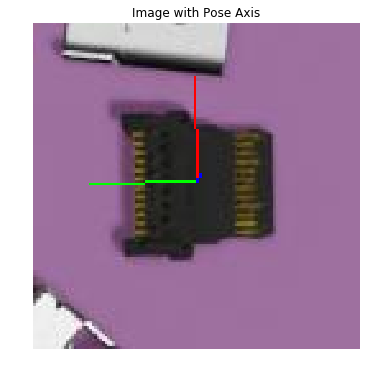

In [5]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from cobot_pvnet import draw_axis

def sanity_check_visualization(pvnet_base_dir, pvnet_annotation, instance_idx=10, crop_size=128):
    """
    Perform a sanity check for visualization of cropped images and overlayed axes.
    
    Args:
    - pvnet_base_dir (str): Base directory of the PVNet dataset.
    - pvnet_annotation (dict): Annotation dictionary containing pose and camera information.
    - instance_idx (int): Index of the instance to visualize.
    - crop_size (int): Size of the crop for visualization.
    """
    # Load the cropped RGB image
    rgb_img_path = os.path.join(pvnet_base_dir, pvnet_annotation['0']['instances'][instance_idx]['cropped_rgb'])
    print(f"Image Path: {rgb_img_path}")
    image = cv2.imread(rgb_img_path)
    
    # Ensure the image is loaded
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {rgb_img_path}")
    
    # Convert the image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Extract transformation and projection details
    T = np.array(pvnet_annotation['0']['instances'][instance_idx]['pose_in_cam'])
    uv = np.array(pvnet_annotation['0']['instances'][instance_idx]['uv'])
    K_cam = np.array(pvnet_annotation['0']['camera_K'])
    
    # Adjust the intrinsic camera matrix for cropping
    K = K_cam.copy()
    K[0, 2] += crop_size // 2 - uv[0]
    K[1, 2] += crop_size // 2 - uv[1]
    
    # Draw the axis on the image
    img_axis = draw_axis(image_rgb, T[:3, :3], T[:3, 3], K)
    
    # Display the image with the overlayed axes
    plt.figure(figsize=(8, 6))
    plt.imshow(img_axis)
    plt.axis('off')
    plt.title("Image with Pose Axis")
    plt.show()

# Example usage
sanity_check_visualization(pvnet_base_dir, pvnet_annotation, instance_idx=2)